In [1]:
import pandas as pd
from os.path import join, exists
from os import listdir
from tqdm import tqdm
from datetime import datetime
import numpy as np
from .preprocess import preprocess_factor_exposure

In [2]:
binance_folder = "/mnt/e/Ubuntu2004/BitcoinQuant/data/binance"
all_symbols = listdir(binance_folder)
all_symbols = [f for f in all_symbols if f.endswith("USDT")]
interval = "1h"
all_data = dict()

In [3]:
for symbol in tqdm(all_symbols):
    symbol_folder = join(binance_folder, symbol)
    interval_folder = join(symbol_folder, interval)
    pkl_file = join(interval_folder, "data.pkl")
    if exists(pkl_file):
        data = pd.read_pickle(pkl_file)
        if len(data) == 6168:
            all_data[symbol] = data

100%|██████████| 151/151 [00:04<00:00, 34.77it/s]


In [4]:
for symbol in all_data.keys():
    close_price = np.array(all_data[symbol]["Close"])
    returns = close_price[1:] / close_price[:-1] - 1
    returns = np.append([0.0], returns)
    all_data[symbol]["returns"] = returns

In [5]:
for symbol in all_data.keys():
    data_symbol_close = all_data[symbol]["Close"]
    data_symbol_open = all_data[symbol]["Open"]
    volatility = (data_symbol_close / data_symbol_open).rolling(24).std() * -1
    all_data[symbol]["volatility"] = volatility

In [6]:
for symbol in all_data.keys():
    all_data[symbol] = all_data[symbol].dropna().reset_index(drop=True)

In [7]:
returns_data = []
for symbol in all_data.keys():
    # returns_data.append(np.array(all_data[symbol]["returns"])[1:])
    symbol_returns = np.array(all_data[symbol]["returns"])[1:].reshape(1, -1)
    returns_data.append(symbol_returns)
returns_data = np.concatenate(returns_data, axis=0)
returns_data.shape


(110, 6144)

In [8]:
factor_data = []
for symbol in all_data.keys():
    symbol_volatility = np.array(all_data[symbol]["volatility"])[:-1].reshape(1, -1)
    factor_data.append(symbol_volatility)
factor_data = np.concatenate(factor_data, axis=0)
factor_data.shape


(110, 6144)

In [9]:
print(True in np.isnan(returns_data), True in np.isnan(factor_data))

False False


In [10]:
from single_factor_analyze import SingleFactorAnalyzeRegression

In [11]:
regression_analyze = SingleFactorAnalyzeRegression(returns_data, factor_data, "volatility", "wls")
regression_analyze.fit()
results = regression_analyze.return_results()

In [12]:
print("t_abs_values_mean: ", results["t_abs_values_mean"])
print("t_abs_values_larger_than_2_ratio: ", results["t_abs_values_larger_than_2_ratio"])
print("t_values_mean: ", results["t_values_mean"])
print("alphas_mean: ", results["alphas_mean"])

t_abs_values_mean:  30.089455233760322
t_abs_values_larger_than_2_ratio:  0.9231770833333334
t_values_mean:  2.801934475222737
alphas_mean:  4.2385441485485216e-05


In [17]:
ols_regression_analyze = SingleFactorAnalyzeRegression(returns_data, factor_data, "volatility", "ols")

In [18]:
ols_regression_analyze.fit()

In [19]:
ols_results = ols_regression_analyze.return_results()

In [20]:
print("t_abs_values_mean: ", ols_results["t_abs_values_mean"])
print("t_abs_values_larger_than_2_ratio: ", ols_results["t_abs_values_larger_than_2_ratio"])
print("t_values_mean: ", ols_results["t_values_mean"])
print("alphas_mean: ", ols_results["alphas_mean"])

t_abs_values_mean:  1.7677060076326583
t_abs_values_larger_than_2_ratio:  0.3650716145833333
t_values_mean:  0.18011785941661107
alphas_mean:  -0.00012251906248223322


In [21]:
from single_factor_analyze import SingleFactorRankICAnalyze

In [22]:
ic_analyze = SingleFactorRankICAnalyze(returns_data, factor_data, "volatility")

In [23]:
ic_analyze.fit()

In [24]:
ic_results = ic_analyze.return_results()

In [25]:
print("rank_ic_values_mean: ", ic_results["rank_ic_values_mean"])
print("rank_ic_values_std: ", ic_results["rank_ic_values_std"])
print("ir: ", ic_results["ir"])
print("rank_ic_values_larger_than_0_ratio: ", ic_results["rank_ic_values_larger_than_0_ratio"])
print("rank_ic_values: ", ic_results["rank_ic_values"])

rank_ic_values_mean:  0.03594686591694405
rank_ic_values_std:  0.2093419852844402
ir:  0.17171359996467883
rank_ic_values_larger_than_0_ratio:  0.5777994791666666
rank_ic_values:  [ 0.25308425  0.11125341  0.05050168 ... -0.31908006 -0.0020612
  0.01987936]


In [26]:
def prepare_factor_data(all_data, factor_name):
    factor_data = {}
    for symbol, df in all_data.items():
        factor_data[symbol] = df[factor_name].copy()
    return factor_data

factor_data_dict = prepare_factor_data(all_data, "volatility")

In [27]:
def quantile_split(factor_values, n_groups=5):
    valid_values = factor_values.dropna()
    quantiles = np.linspace(0, 1, n_groups + 1)
    bins = valid_values.quantile(quantiles).values
    bins[0] = -np.inf
    bins[-1] = np.inf
    groups = pd.cut(factor_values, bins=bins, labels=range(1, n_groups + 1), include_lowest=True)
    return groups

In [28]:
test_factor_data = {}
for symbol in factor_data_dict.keys():
    test_factor_data[symbol] = factor_data_dict[symbol][30]
test_factor_data = pd.Series(test_factor_data)
# print(test_factor_data)
test_groups = quantile_split(test_factor_data, n_groups=5)
print(test_groups)
print((test_groups==1).tolist())
test_groups_dict = {}
for i in range(1, 6):
    test_groups_dict[i] = test_factor_data[test_groups == i].index.tolist()
for i in range(1, 6):
    print(i, sorted([test_factor_data[symbol] for symbol in test_groups_dict[i]]))

1INCHUSDT    4
ADAUSDT      4
ALGOUSDT     4
ALICEUSDT    3
ALPHAUSDT    4
            ..
XTZUSDT      3
ZECUSDT      4
ZENUSDT      3
ZILUSDT      3
ZRXUSDT      2
Length: 110, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
[False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, True, True, False, False, False, False, True, True, False, False, True, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, True, True, False, False, False, False, True, False, False, False, False, False, True, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
1 [-0.02688908

In [29]:
def apply_transaction_cost(portfolio_value, turnover_rate, fee_rate):
    cost = portfolio_value * turnover_rate * fee_rate
    return max(portfolio_value - cost, 0.0)

In [30]:
def stratified_backtest(data, factor_data_dict, n_groups=5, holding_period=8, fee_rate=0.001):
    portfolio_returns = {g: [] for g in range(1, n_groups + 1)}
    portfolio_values = {g: [1.0] for g in range(1, n_groups + 1)}
    group_composition = {g: [] for g in range(1, n_groups + 1)} #记录各期持仓组成

    current_holdings = {g: {} for g in range(1, n_groups + 1)} #记录当前期持仓
    rebalance_times = [] #记录调仓时间
    times_length = len(data["ADAUSDT"]["Close_Time"])

    for current_time_index in range(holding_period, times_length, holding_period):
        rebalance_times.append(current_time_index)
        
        # Step 1: 计算当期收益（未扣除手续费）
        for g in range(1, n_groups + 1):
            if not current_holdings[g]:
                portfolio_returns[g].append(0.0)
                portfolio_values[g].append(portfolio_values[g][-1])
                continue

            current_value = sum(
                shares * data[symbol]["Close"][current_time_index] for symbol, (shares, _) in current_holdings[g].items())
            prev_value = sum(
                shares * entry_price for symbol, (shares, entry_price) in current_holdings[g].items())
            period_return_before_return = (current_value - prev_value) / prev_value if prev_value > 0 else 0.0
            portfolio_values[g].append(portfolio_values[g][-1] * (1 + period_return_before_return))
        
        # Step 2: 调仓并计算手续费
        current_factors = {
            symbol: factor_data_dict[symbol][current_time_index]
            for symbol in data.keys() if current_time_index < len(factor_data_dict[symbol])
        }
        factor_series = pd.Series(current_factors)
        # print(factor_series)
        # normalize factor series
        norm_factor_series = preprocess_factor_exposure(factor_series.values, "median")
        for i in range(len(norm_factor_series)):
            factor_series[i] = norm_factor_series[i]
        # print(factor_series)

        groups = quantile_split(factor_series, n_groups)

        # 更新持仓
        new_holdings = {g: {} for g in range(1, n_groups + 1)}
        for g in range(1, n_groups + 1):
            group_symbols = groups[groups == g].index.tolist()
            group_composition[g].append((current_time_index, group_symbols))
            portfolio_value_before_cost = portfolio_values[g][-1]

            if not group_symbols or portfolio_value_before_cost <= 0:
                continue
            
            # 计算换手率
            turnover = 0.0
            # 卖出旧持仓
            for symbol in list(current_holdings[g].keys()):
                if symbol not in group_symbols:
                    shares, entry_price = current_holdings[g].pop(symbol)
                    price = data[symbol]["Close"][current_time_index]
                    turnover += shares * price
            
            # 调整新持仓
            target_value_per_asset = portfolio_value_before_cost / len(group_symbols)
            for symbol in group_symbols:
                price = data[symbol]["Close"][current_time_index]
                target_shares = target_value_per_asset / price
                if symbol in current_holdings[g]:
                    old_shares, old_price = current_holdings[g][symbol]
                    turnover += abs(old_shares - target_shares) * price
                else:
                    turnover += target_shares * price
                new_holdings[g][symbol] = (target_shares, price)
            
            # 计算换手率并扣除手续费
            turnover_rate = turnover / portfolio_value_before_cost if portfolio_value_before_cost > 0 else 0.0
            portfolio_value_after_cost = apply_transaction_cost(portfolio_value_before_cost, turnover_rate, fee_rate)
            portfolio_values[g][-1] = portfolio_value_after_cost

            prev_value = portfolio_values[g][-2]
            actual_return = (portfolio_value_after_cost - prev_value) / prev_value if prev_value > 0 else 0.0
            portfolio_returns[g].append(actual_return)

        current_holdings = new_holdings.copy()

    # 处理最后一次调仓后的剩余持仓
    last_time_index = rebalance_times[-1]
    end_time_index = times_length - 1
    if last_time_index < end_time_index:
        for g in range(1, n_groups + 1):
            if not current_holdings[g]:
                continue
            current_value = sum(
                shares * data[symbol]["Close"][end_time_index]
                for symbol, (shares, _) in current_holdings[g].items()
            )
            prev_value = sum(
                shares * entry_price for symbol, (shares, entry_price) in current_holdings[g].items()
            )
            turnover_rate = 1.0
            portfolio_value_after_cost = apply_transaction_cost(current_value, turnover_rate, fee_rate)
            actual_return = (portfolio_value_after_cost - prev_value) / prev_value if prev_value > 0 else 0.0
            portfolio_returns[g].append(actual_return)
            portfolio_values[g].append(portfolio_value_after_cost)

    rebalance_times.append(end_time_index)

    

    return {
        "portfolio_returns": portfolio_returns,
        "portfolio_values": portfolio_values,
        "group_composition": group_composition,
        "rebalance_times": rebalance_times
    }

In [31]:
results = stratified_backtest(all_data, factor_data_dict, n_groups=5, holding_period=1, fee_rate=0.001)

/tmp/ipykernel_3213572/2546368100.py:37: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  factor_series[i] = norm_factor_series[i]
/tmp/ipykernel_3213572/2546368100.py:37: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  factor_series[i] = norm_factor_series[i]
/tmp/ipykernel_3213572/2546368100.py:37: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  factor_series[i] = norm_factor_series[i]
/tmp/ipykernel_3213572/2546368100.py:

In [32]:
portfolio_returns = results["portfolio_returns"]
len(portfolio_returns[1])

6145

In [33]:
portfolio_values = results["portfolio_values"]
print(portfolio_values)

{1: [1.0, 0.999, 0.99017220185123, 0.9910344704093207, 0.991533523291181, 0.9837554138201325, 0.9913514038958933, 0.9923046326130014, 0.991425033439281, 0.9880408429956374, 0.989936820902601, 0.9860855640085441, 0.9848352371778588, 0.9889549591416394, 0.9851446721640926, 0.9882889118312265, 0.9913875739080857, 0.9934802663566302, 0.9906262625653108, 0.9825282685987008, 0.9801655944770193, 0.9817853387344402, 0.9829623511227086, 0.9877741048794557, 0.98719372358952, 0.9853596303596035, 0.9888975184732276, 0.986597879963555, 0.9836942725147917, 0.9787011293526324, 0.9863360213014608, 0.976883686758418, 0.9793976563564263, 0.9783787489047622, 0.9769038570142375, 0.9839003753149077, 0.9873774738970743, 0.9826075497952508, 0.9930574355682659, 0.9871957895964876, 0.9811700047949597, 0.9662774783959555, 0.9738798241073975, 0.9721131652264681, 0.9675510715986603, 0.9566341977227835, 0.9629970932614039, 0.9760868900845934, 0.9799144272594889, 0.9714712317154278, 0.9664933747691147, 0.9635228155

In [34]:
print(np.mean(portfolio_values[1]))

0.3217157551039619


In [35]:
import matplotlib.pyplot as plt

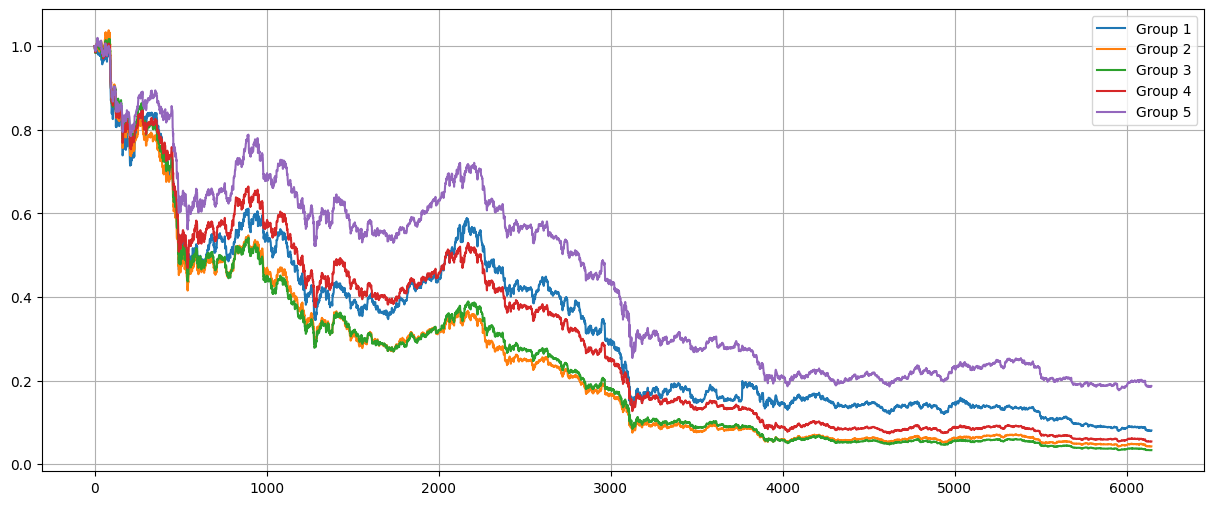

In [36]:
plt.figure(figsize=(15, 6))
for g in range(1, 6):
    plt.plot(portfolio_values[g], label=f"Group {g}")
plt.legend()
plt.grid(True)
plt.show()

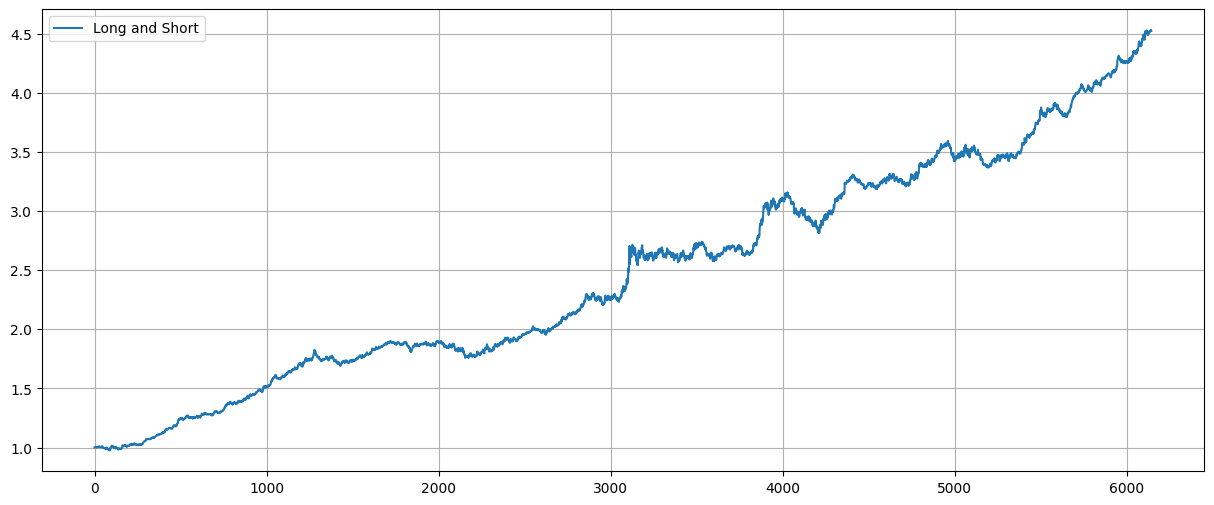

In [39]:
top_returns = results["portfolio_returns"][5]
bottom_returns = results["portfolio_returns"][3]
long_and_short_returns = [top_returns[i] - bottom_returns[i] for i in range(len(top_returns))]
long_and_short_values = [long_and_short_returns[i] + 1 for i in range(len(long_and_short_returns))]
long_and_short_values = np.cumprod(long_and_short_values)
plt.figure(figsize=(15, 6))
plt.plot(long_and_short_values, label="Long and Short")
plt.grid(True)
plt.legend()

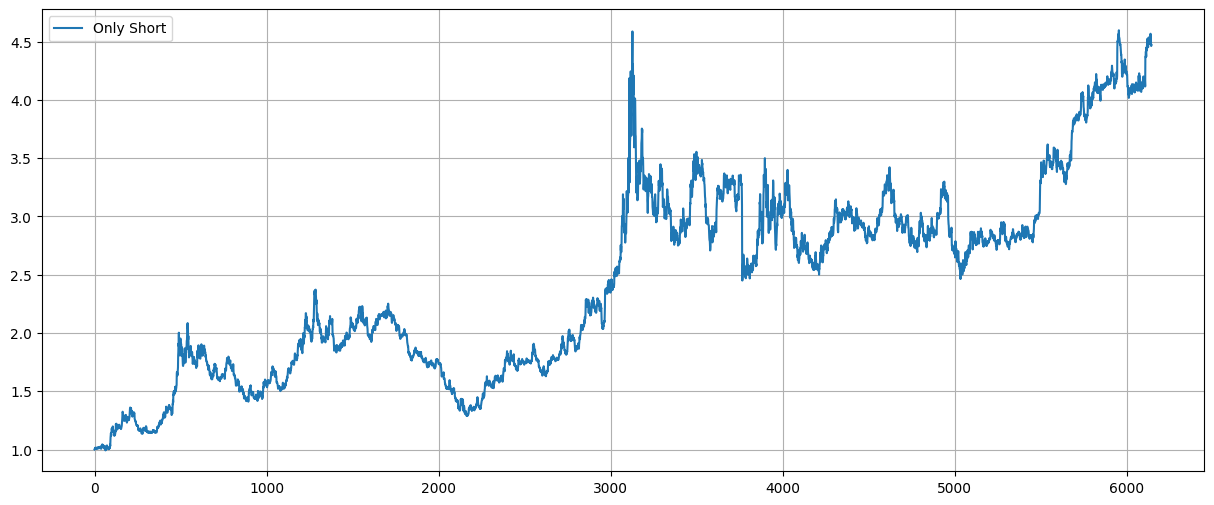

In [38]:
short_returns = results["portfolio_returns"][1]
short_values = [1 - short_returns[i] for i in range(len(short_returns))]
short_values = np.cumprod(short_values)
plt.figure(figsize=(15, 6))
plt.plot(short_values, label="Only Short")
plt.grid(True)
plt.legend()